# <center> SENTIMENT ANALYSIS PROJECT (I)<center>

## Introduction

Here, I am going to analyze the 2017 reviews of a photo company. The data is provided by the company. I will start with importing necessary libraries and reading the data into a DataFrame.

In [1]:
# import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime as dt

import nltk
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('stopwords')

from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import unicodedata
#import contractions
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize 
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re

from wordcloud import WordCloud

In [3]:
#read the data into a DataFrame

df  = pd.read_excel('photo_company_reviews.xlsx')

## 1. Data Wrangling

The company puts importance on privacy of the company and also its customers. So, I am going to check the column names first before printing out any part of the data to keep privacy. 

In [78]:
df.columns

Index(['isim', 'soyisim', 'cinsiyet', 'not', 'ürün', 'yorum', 'Yorum Tarihi',
       'Yorumcu Numarası'],
      dtype='object')

Note that the column names are in a different language. Not part of the original analysis, but let me translate them to English, so that it makes sense to all. I also added explanations where necessary to provide better understanding of this project.

In [79]:
df.columns = ['name', 'lastname', 'sex', 'rating', 'product', 'review', 'review_date', 'reviewer_id']

Let's get some info on the data.

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5157 entries, 0 to 5156
Data columns (total 8 columns):
name           5157 non-null object
lastname       5157 non-null object
sex            5157 non-null object
rating         4968 non-null float64
product        4989 non-null object
review         5016 non-null object
review_date    5157 non-null object
reviewer_id    5157 non-null int64
dtypes: float64(1), int64(1), object(6)
memory usage: 322.4+ KB


There are 5157 rows and 8 columns in the dataset. I have 6 columns of datatype string, 1 of float and 1 of integer. Columns 'rating', 'product' and 'review' have missing values. The columns are:

1. name – a string type data storing the name of the reviewer 
2. lastname – a string type data storing the lastname of the reviewer
3. sex - a string type data storing the sex of the reviewer 
4. rating - rating given by the reviewer for the type of product / service
5. product - a string type data storing the type of product / service 
6. review - a string type data storing the text of the review
7. review_date - a string type data storing date the review was provided (I will convert to type datetime)
8. reviewer_id - unique integer number of the reviewer  

There is redundancy in columns. Since 'reviewer_id' provides enough information on the reviewers, I am going to drop the 'name' and 'lastname' columns in order to take care of the redundancy and keep privacy of the customers who provided the reviews to the company.

In [81]:
df.drop(['name', 'lastname'], axis=1, inplace=True)
df.head()

,sex,rating,product,review,review_date,reviewer_id
0,k,5.0,hizmet,"İstanbul'da en sevdiğim mekan, analog dostu. M...",03/08/2017,44720
1,k,5.0,Stüdyo,KESİNLİKLE ÇOK GÜZEL BİR STÜDYO,10/17/2017,46945
2,k,5.0,Hizmet,Burayı hep sevdim,01/03/2017,92805
3,e,5.0,Düğün,"Düğün fotoğrafı için gitmiştik, çok güzel çeki...",01/19/2017,51670
4,k,2.0,Hizmet,O kadar iyi diil tabi. Isim var sadece,11/05/2017,79719


Let's also make sense of the 'sex' column.

In [82]:
df['sex'].value_counts()

e    2639
k    2518
Name: sex, dtype: int64

Here 'e' stands for male and 'k' for female. First, I will change them into 'm' and 'f'. Second, I will convert the datatype to categorical for efficient computing. Category datatypes take up less memory and enable faster computing. 

In [83]:
# translate
df['sex'] = ['f' if row == 'k' else 'm' for row in df.sex]

# check the translation
df.head()

,sex,rating,product,review,review_date,reviewer_id
0,f,5.0,hizmet,"İstanbul'da en sevdiğim mekan, analog dostu. M...",03/08/2017,44720
1,f,5.0,Stüdyo,KESİNLİKLE ÇOK GÜZEL BİR STÜDYO,10/17/2017,46945
2,f,5.0,Hizmet,Burayı hep sevdim,01/03/2017,92805
3,m,5.0,Düğün,"Düğün fotoğrafı için gitmiştik, çok güzel çeki...",01/19/2017,51670
4,f,2.0,Hizmet,O kadar iyi diil tabi. Isim var sadece,11/05/2017,79719


In [84]:
# type conversion from string into category
df['sex'] = df.sex.astype('category')

# check the result
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5157 entries, 0 to 5156
Data columns (total 6 columns):
sex            5157 non-null category
rating         4968 non-null float64
product        4989 non-null object
review         5016 non-null object
review_date    5157 non-null object
reviewer_id    5157 non-null int64
dtypes: category(1), float64(1), int64(1), object(3)
memory usage: 206.7+ KB


Time to look at 'product' column:

In [85]:
# make entries lowercase
df['product'] = df['product'].str.lower()

In [86]:
df['product'].value_counts()

hizmet       3792
düğün         284
fiyat         230
sanat         167
stüdyo        123
vesikalık     122
nişan         117
mekan         103
dış çekim      21
makine         16
amatör         14
Name: product, dtype: int64

Translation of the 'product' column thru the help of a "dictionary":

In [87]:
dict = {'hizmet':'service', 
        'düğün':'wedding',
        'fiyat':'price',
        'sanat':'art',
        'stüdyo':'studio',
        'vesikalık':'passport',
        'nişan':'engagement',
        'mekan':'facility',
        'dış çekim':'outdoors',
        'makine':'camera',
        'amatör':'self-taken'
        }
df['product'] = df['product'].map(dict)
df.head()

,sex,rating,product,review,review_date,reviewer_id
0,f,5.0,service,"İstanbul'da en sevdiğim mekan, analog dostu. M...",03/08/2017,44720
1,f,5.0,studio,KESİNLİKLE ÇOK GÜZEL BİR STÜDYO,10/17/2017,46945
2,f,5.0,service,Burayı hep sevdim,01/03/2017,92805
3,m,5.0,wedding,"Düğün fotoğrafı için gitmiştik, çok güzel çeki...",01/19/2017,51670
4,f,2.0,service,O kadar iyi diil tabi. Isim var sadece,11/05/2017,79719


In [88]:
# Convert to category datatype
df['product'] = df['product'].astype('category')

# check the conversion
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5157 entries, 0 to 5156
Data columns (total 6 columns):
sex            5157 non-null category
rating         4968 non-null float64
product        4989 non-null category
review         5016 non-null object
review_date    5157 non-null object
reviewer_id    5157 non-null int64
dtypes: category(2), float64(1), int64(1), object(2)
memory usage: 171.8+ KB


Now, let's convert 'review_date' to datetime object to have a more 'user-friendly' column.

In [89]:
df['review_date'] = pd.to_datetime(df['review_date'])

# check the data types to see the result
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5157 entries, 0 to 5156
Data columns (total 6 columns):
sex            5157 non-null category
rating         4968 non-null float64
product        4989 non-null category
review         5016 non-null object
review_date    5157 non-null datetime64[ns]
reviewer_id    5157 non-null int64
dtypes: category(2), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 171.8+ KB


Let's check if there is any duplication in data:

In [90]:
df.nunique()

sex               2
rating            5
product          11
review         1081
review_date     350
reviewer_id    1088
dtype: int64

I am going to drop the duplicate rows.

In [91]:
df.drop_duplicates(inplace = True)

# check to see how many rows left
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1157 entries, 0 to 4128
Data columns (total 6 columns):
sex            1157 non-null category
rating         1115 non-null float64
product        1120 non-null category
review         1126 non-null object
review_date    1157 non-null datetime64[ns]
reviewer_id    1157 non-null int64
dtypes: category(2), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 47.9+ KB


Let's see how many entries are missing from each column now:

In [92]:
df.isnull().sum()

sex             0
rating         42
product        37
review         31
review_date     0
reviewer_id     0
dtype: int64

In [93]:
# drop rows with missing entries
df.dropna(subset=['review', 'rating', 'product'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1109 entries, 0 to 4128
Data columns (total 6 columns):
sex            1109 non-null category
rating         1109 non-null float64
product        1109 non-null category
review         1109 non-null object
review_date    1109 non-null datetime64[ns]
reviewer_id    1109 non-null int64
dtypes: category(2), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 46.0+ KB


Here, I will check the unique number of features.

In [94]:
print('The total number of reviewers: {}'. format(df.reviewer_id.nunique()))
print('The total number of reviews: {}'. format(len(df)))
print('The total number of reiewed products or service: {}'. format(df['product'].nunique()))
print('The total number of review days: {}'. format(df.review_date.nunique()))
print('The total number of unique reviews: {}'. format(df.review.nunique()))

The total number of reviewers: 1040
The total number of reviews: 1109
The total number of reiewed products or service: 11
The total number of review days: 348
The total number of unique reviews: 1064


In total, 1040 reviewers wrote 1109 reviews on 11 products/services/topics in 348 unique days. Some reviewers wrote more than one review and some reviews are the same. 

I am going to drop the rows with duplicate reviews.

In [95]:
df.drop_duplicates(subset='review', keep='first', inplace=True)

In [96]:
# check the remaining DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1064 entries, 0 to 4128
Data columns (total 6 columns):
sex            1064 non-null category
rating         1064 non-null float64
product        1064 non-null category
review         1064 non-null object
review_date    1064 non-null datetime64[ns]
reviewer_id    1064 non-null int64
dtypes: category(2), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 44.1+ KB


Now, let's check the summary statistics of the 'rating' column:

In [97]:
df['rating'].describe()

count    1064.000000
mean        4.178571
std         1.495075
min         1.000000
25%         4.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: rating, dtype: float64

5.0 is the maximum rating, 4.18 is the average. The standard deviation is around 1.5. 

### Text preprocessing

I need to do some preprocessing before I build any model. First, I am going to make sure all entries in the 'review' column is of type 'string'. 

In [98]:
df['review'] = df['review'].astype(str)

Next, I will normalize the text, i.e. I will use 7 functions inside a function that strips the html tags, converts the text to lower_case, lemmatizes the text, removes extra lines, accented or special characters, digits and stopwords.

In [100]:
# html_tags removal
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

# accented_chars removal
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

# special_characters removal
def remove_special_characters(text, remove_digits=True):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

# Lemmatization
lemmatizer=WordNetLemmatizer()
                     
def lemmatize_text(text):
    text = " ".join(lemmatizer.lemmatize(w) for w in text.split(' '))
    return text

# Creating stopwordlist and editing 
stopword_list= stopwords.words('turkish')
    
                     
def remove_stopwords(text, stop_words=stopword_list):
    tokens = [w for w in nltk.word_tokenize(text) if w not in stop_words]
    return ' '.join(tokens)    

In [101]:
def normalize_text(text, html_stripping=True, accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    
    # remove extra newlines
    text = re.sub(r'[\r|\n|\r\n]+', ' ',text)
    
    # remove underscores
    text = re.sub('_+', '', text)
    
    # strip HTML
    if html_stripping:
        text = strip_html_tags(text)
        
    # remove accented characters
    if accented_char_removal:
        text = remove_accented_chars(text)
        
    # lowercase the text    
    if text_lower_case:
        text = text.lower()
           
    # remove stopwords
    if stopword_removal:
        text = remove_stopwords(text)
        
    # remove special characters and\or digits    
    if special_char_removal:
        # insert spaces between special characters to isolate them    
        special_char_pattern = re.compile(r'([{.(-)!}])')
        text = special_char_pattern.sub(" \\1 ", text)
        text = remove_special_characters(text, remove_digits=remove_digits)  
    
    # remove extra whitespace
    text = re.sub(' +', ' ', text)
        
    # lemmatize text
    if text_lemmatization:
        text = lemmatize_text(text)
        
    # remove any remaining stopwords
    if stopword_removal:
        text = remove_stopwords(text)
       
    return text

Let's see the function in action:

In [103]:
df['clean_text'] = df['review'].map(lambda text: normalize_text(text))
df.head(5)

,sex,rating,product,review,review_date,reviewer_id,clean_text
0,f,5.0,service,"İstanbul'da en sevdiğim mekan, analog dostu. M...",2017-03-08,44720,istanbulda sevdigim mekan analog dostu minicik...
1,f,5.0,studio,KESİNLİKLE ÇOK GÜZEL BİR STÜDYO,2017-10-17,46945,kesinlikle cok guzel bir studyo
2,f,5.0,service,Burayı hep sevdim,2017-01-03,92805,buray sevdim
3,m,5.0,wedding,"Düğün fotoğrafı için gitmiştik, çok güzel çeki...",2017-01-19,51670,dugun fotograf icin gitmistik cok guzel cekiml...
4,f,2.0,service,O kadar iyi diil tabi. Isim var sadece,2017-11-05,79719,kadar iyi diil tabi isim var sadece


### Word Cloud

Now, we will plot a word cloud to get a pictorial feel of which words occur the most in the reviews.

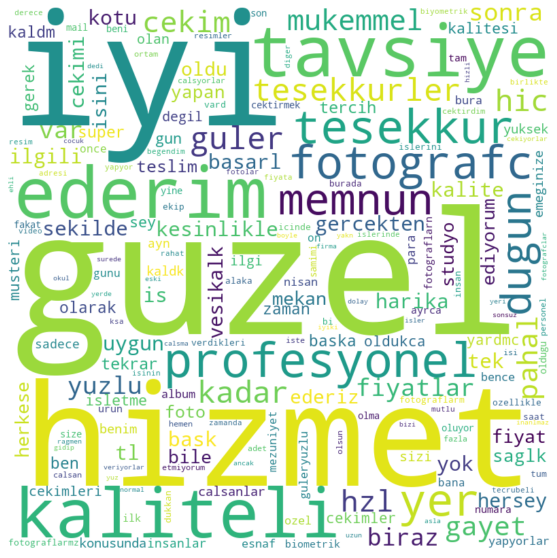

In [104]:
%matplotlib inline
import pdb
big_list = ''
big_list = [''.join(row) for row in df.clean_text]
big_string = ','.join(big_list)

my_cloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                collocations=False,
                stopwords=['bir', 'cok', 'fotograf', 'fotograflar', 'icin'],
                min_font_size = 10).generate(big_string)
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(my_cloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [105]:
# one last check for null values before saving
df.isnull().sum()

sex            0
rating         0
product        0
review         0
review_date    0
reviewer_id    0
clean_text     0
dtype: int64

I will save the cleaned text to disk for further analysis.

In [106]:
df.to_csv('1_wrangled.csv', sep=',', encoding='utf-8')

### Summary

- I read the data from an Excel file into a DataFrame, 
- changed the column names to lowercase English with underscores between words (snake_case naming convention),  
- dropped redundant columns and rows,
- dropped rows with missing values,
- converted the 'sex' and 'product' columns to categorical type for efficient computing,
- converted the 'review_date' column into datetime type for better analysis,
- preprocessed text for machine learning by 
    - stripping the html tags, 
    - converting the text to lower_case,  
    - lemmatizing the text,  
    - removing extra lines, accented or special characters, digits and stopwords.
- added resulting 'clean_text' as a new column
- visualized most common words in the reviews by a WordCloud,
- saved the new DataFrame as a csv file for further Exploratory Data Analysis (EDA). 